In [21]:
from torchinfo import summary
# from util_plots import *
from util_plots2 import *
from util_dataload import *
from util_train import *

import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import time
from datetime import datetime
import random
from tqdm.auto import tqdm
import os
import requests
import zipfile

from pathlib import Path
import pathlib


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print("torch version: ", torch.__version__)



cuda
torch version:  1.13.1


In [22]:
# Setup path to data folder
data_path = Path("view_dset_01_splitted_aug/cc_splitted/")
image_path = data_path 

train_dir = image_path / "train"
test_dir = image_path / "test"

file_labels = []
for name in os.listdir(train_dir):
    file_labels.append(name)

print("Train directory: ",train_dir)
print("Test directory: ",test_dir)
print("Labels: ",file_labels)

Train directory:  view_dset_01_splitted_aug\cc_splitted\train
Test directory:  view_dset_01_splitted_aug\cc_splitted\test
Labels:  ['0', '1']


Path: view_dset_01_splitted_aug\cc_splitted\train\0  |  # of images:  2959
Path: view_dset_01_splitted_aug\cc_splitted\train\1  |  # of images:  4068
---
Path: view_dset_01_splitted_aug\cc_splitted\test\0  |  # of images:  5240
Path: view_dset_01_splitted_aug\cc_splitted\test\1  |  # of images:  114
---
Train size: 7027
Test size: 5354


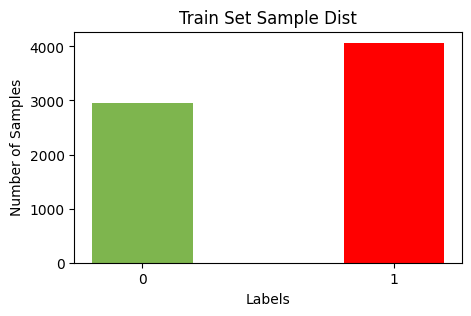

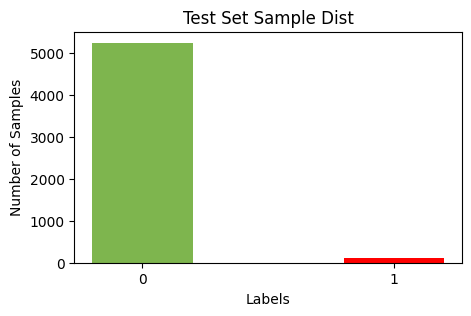

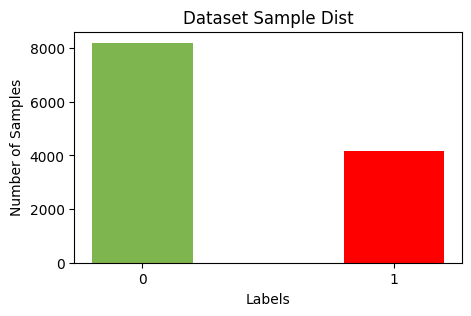

In [35]:
train_img_len = []
test_img_len = []

for file_name in [train_dir, test_dir]:
    for label_index in range(len(file_labels)):
        label_path = file_name/ file_labels[label_index]
        lst = os.listdir(label_path)
        number_of_imgs = len(lst)
        print("Path:", label_path, " |  # of images: ", number_of_imgs)

        if file_name == train_dir:
            train_img_len.append(number_of_imgs)
        if file_name == test_dir:
            test_img_len.append(number_of_imgs)
    print("---")


print("Train size:",sum(train_img_len))
print("Test size:",sum(test_img_len))

bar_colors = ['#7eb54e','red']

dataset_all_len = [sum(x) for x in zip(train_img_len, test_img_len)]

# print(train_img_len)
# print(test_img_len)
# print(dataset_all_len)

single_bar_plot_dataset_53(file_labels, train_img_len, "Train Set Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )
single_bar_plot_dataset_53(file_labels, test_img_len, "Test Set Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )
single_bar_plot_dataset_53(file_labels, dataset_all_len, "Dataset Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )


In [36]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [28]:
!dir 

 Volume in drive C has no label.
 Volume Serial Number is ACA4-631C

 Directory of c:\Users\unatt\OneDrive\Masa�st�\rsna512

20.03.2023  17:23    <DIR>          .
20.03.2023  13:20    <DIR>          ..
20.03.2023  17:23               200 20_03_2023__17_23__test_acc.txt
20.03.2023  17:23               201 20_03_2023__17_23__test_loss.txt
20.03.2023  17:23               200 20_03_2023__17_23__train_acc.txt
20.03.2023  17:23               202 20_03_2023__17_23__train_loss.txt
08.03.2023  16:43     3.755.892.491 archive (3).zip
20.03.2023  15:51             8.138 data_aug.ipynb
13.03.2023  23:05         2.253.674 data_load.ipynb
20.03.2023  17:50             3.042 data_remove.ipynb
20.03.2023  11:47               220 data_util_split.py
13.03.2023  22:18         1.083.138 ensemble1.ipynb
08.03.2023  20:56    <DIR>          images
08.03.2023  01:30            41.295 load_dset.ipynb
20.03.2023  15:51    <DIR>          new_augmented
22.02.2023  14:16             1.545 plot_params.py
20.03.2023

In [24]:
import torchvision.datasets as datasets
from torch.utils.data import WeightedRandomSampler

dset = datasets.ImageFolder(train_dir, transform=simple_transform)

class_weights = [1, 2]
sample_weights = [0] * len(dset)

for idx, (data, label) in enumerate(dset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=len(sample_weights),
                                replacement=True)
# train_loader= DataLoader(
#       dset,
#       batch_size=16,
#       num_workers= os.cpu_count(),
#       sampler=sampler )


In [37]:
from util_dataload import create_dataloader, get_class_names_dloader

BATCH_SIZE = 8

train_dataloader = create_dataloader(
                            file_dir=test_dir,
                            shuffle_opt= True,
                            transform=simple_transform, 
                            batch_size=BATCH_SIZE) 

# train_dataloader = create_dataloader_w_weights(
#                             file_dir=train_dir,
#                             transform=simple_transform, 
#                             batch_size=BATCH_SIZE,
#                             sampler=sampler) 

test_dataloader = create_dataloader(
                            file_dir=test_dir,
                            shuffle_opt= False,
                            transform=simple_transform, 
                            batch_size=BATCH_SIZE) 

class_names = get_class_names_dloader(file_dir=train_dir, transform=simple_transform)

print("Batch size: ", BATCH_SIZE)
print("Number of train batches:",len(train_dataloader))
print("Number of test batches:",len(test_dataloader))

print("Number of classes: ",len(class_names))
print("Classes: ", class_names)

Batch size:  8
Number of train batches: 670
Number of test batches: 670
Number of classes:  2
Classes:  ['0', '1']


# Create Pre-Trained Model

In [38]:
model_resNet0 = torchvision.models.resnet50(weights=True).to(device)

# # Freeze all base layers in the "features" section of the model (the feature extractor)
# for param in model_resNet0.features.parameters():
#     param.requires_grad = True

c:\Users\unatt\anaconda3\envs\pytorch_env_v_1_13_1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
model_resNet0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# # make input one channel
# model_resNet0.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), 
#                       stride=(2, 2), padding=(3, 3), bias=False)

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
DROPOUT_PROB = 0.1

# model_resNet0.fc = torch.nn.Sequential(
#     torch.nn.Dropout(p=DROPOUT_PROB, inplace=True), 
#     torch.nn.Linear(in_features=2048, 
#                     out_features=output_shape,
#                     bias=True)
#     ).to(device)

model_resNet0.fc = torch.nn.Linear(in_features=2048, 
                    out_features=output_shape,
                    bias=True).to(device)


In [11]:
summary(
    model=model_resNet0, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
ResNet (ResNet)                          [32, 3, 224, 224]  [32, 2]            --                 True
├─Conv2d (conv1)                         [32, 3, 224, 224]  [32, 64, 112, 112] 9,408              True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112] [32, 64, 112, 112] 128                True
├─ReLU (relu)                            [32, 64, 112, 112] [32, 64, 112, 112] --                 --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112] [32, 64, 56, 56]   --                 --
├─Sequential (layer1)                    [32, 64, 56, 56]   [32, 256, 56, 56]  --                 True
│    └─Bottleneck (0)                    [32, 64, 56, 56]   [32, 256, 56, 56]  --                 True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]   [32, 64, 56, 56]   4,096              True
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56]   [32, 64, 56,

In [29]:
model_resNet0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
from util_train import train

LR = 0.00001
loss_func = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model_resNet0.parameters(), lr=LR)
no_of_epochs = 10

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_train = time.time()
model_efficientNet0_acc_loss_vals = train(model=model_resNet0,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=test_dataloader,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=no_of_epochs,
                                        device=device,
                                        log_txt_saver=True)

end_time_train = time.time()

print(f"Total training time: {end_time_train-start_time_train:.3f} (s).")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1528 | train_accuracy: 0.9612 | test_loss: 0.0934 | test_accuracy: 0.9776
Epoch: 2 | train_loss: 0.0914 | train_accuracy: 0.9787 | test_loss: 0.0658 | test_accuracy: 0.9778
Epoch: 3 | train_loss: 0.0629 | train_accuracy: 0.9808 | test_loss: 0.0444 | test_accuracy: 0.9907
Epoch: 4 | train_loss: 0.0271 | train_accuracy: 0.9927 | test_loss: 0.0123 | test_accuracy: 0.9991
Epoch: 5 | train_loss: 0.0111 | train_accuracy: 0.9978 | test_loss: 0.0208 | test_accuracy: 0.9961
Epoch: 6 | train_loss: 0.0065 | train_accuracy: 0.9991 | test_loss: 0.0085 | test_accuracy: 0.9979
Epoch: 7 | train_loss: 0.0080 | train_accuracy: 0.9979 | test_loss: 0.0135 | test_accuracy: 0.9970
Epoch: 8 | train_loss: 0.0066 | train_accuracy: 0.9979 | test_loss: 0.0042 | test_accuracy: 0.9989
Epoch: 9 | train_loss: 0.0053 | train_accuracy: 0.9983 | test_loss: 0.0042 | test_accuracy: 0.9994
Epoch: 10 | train_loss: 0.0031 | train_accuracy: 0.9994 | test_loss: 0.0004 | test_accuracy: 1.0000
Total tra

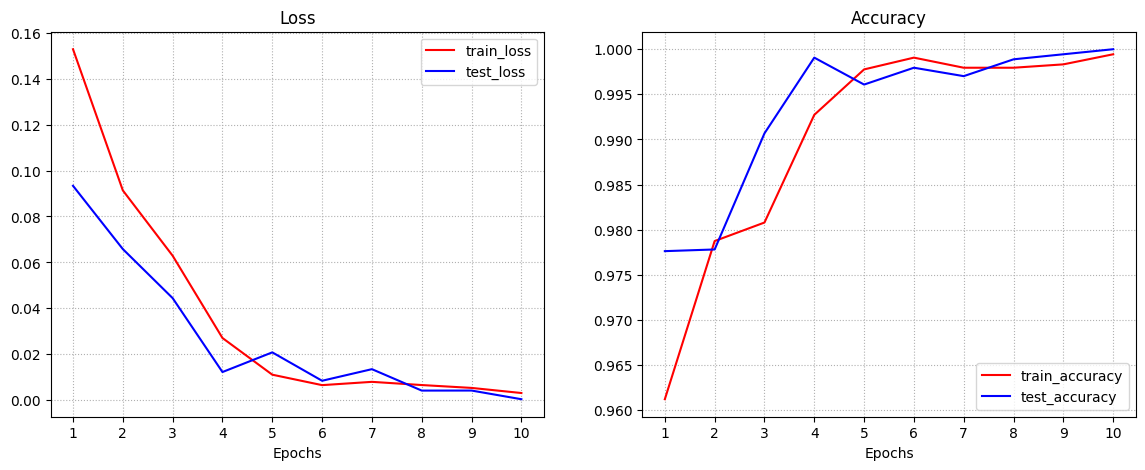

In [42]:
from util_plots2 import plot_loss_accuracy_grid2

def plot_loss_accuracy_grid2_v2(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    x_ticks_range = 1

    # epochs = range(len(results["train_loss"]))
    epochs = np.arange(1, len(results["train_loss"])+1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_loss, label="train_loss", color = "red")
    plt.plot(epochs, test_loss, label="test_loss", color = "blue")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)
    plt.grid(True,linestyle=':')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_accuracy, label="train_accuracy", color = "red")
    plt.plot(epochs, test_accuracy, label="test_accuracy", color = "blue")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True,linestyle=':')


plot_loss_accuracy_grid2_v2(model_efficientNet0_acc_loss_vals)

# Test & Predictions

In [43]:
test_preds = []
model_resNet0.eval()

start_time_testset = time.time()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    
    test_logits = model_resNet0(X)
    pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
    pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

    test_preds.append(pred_labels) 

end_time_testset = time.time()
print(f"Total testing time: {end_time_testset-start_time_testset:.3f} (s).")

test_preds = torch.cat(test_preds).cpu()
test_truth = torch.cat([y for X, y in test_dataloader])

  0%|          | 0/670 [00:33<?, ?it/s]

Total testing time: 87.882 (s).


Main Parameters of model:Batch size: 8 
Epochs: 10 
Learning Rate: 1e-05 
Dropout Prob: 0.1 
Training time: 1814.006


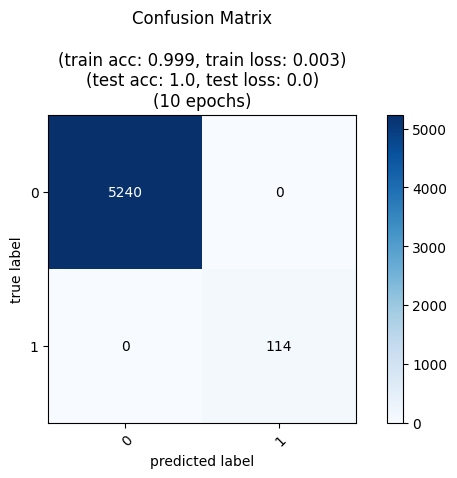

In [44]:
# !pip install -q torchmetrics -U mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix_multiclass = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_matrix_tensor = conf_matrix_multiclass(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), 
    class_names=class_names,
    figsize=(8, 4),
    colorbar=True,
    # cmap = 'magma_r'
)

last_train_acc = round(model_efficientNet0_acc_loss_vals['train_acc'][no_of_epochs-1],3)
last_train_loss = round(model_efficientNet0_acc_loss_vals['train_loss'][no_of_epochs-1],3)
last_test_acc = round(model_efficientNet0_acc_loss_vals['test_acc'][no_of_epochs-1],3)
last_test_loss = round(model_efficientNet0_acc_loss_vals['test_loss'][no_of_epochs-1],3)

ax.set_title(f"Confusion Matrix"
    +f"\n\n"+
    f"(train acc: {last_train_acc}, train loss: {last_train_loss})\n" +
    f"(test acc: {last_test_acc}, test loss: {last_test_loss})\n" +
    f"({no_of_epochs} epochs)"
    )

print(f"Main Parameters of model:"+ 
      f"Batch size: {BATCH_SIZE} \n"+
      f"Epochs: {no_of_epochs} \n"+
      f"Learning Rate: {LR} \n"+
      f"Dropout Prob: {DROPOUT_PROB} \n"+
      f"Training time: {end_time_train-start_time_train:.3f}"
      )

# Single Image Prediction

In [50]:
simple_transform2 = transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [54]:
def pred_single_img(image_path, model, transform, class_names, device=device):
  image = Image.open(image_path)
  transformed_image = transform(image)
  print(transformed_image.shape)

  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class = class_names[pred_label.cpu()]
  
  pred_prob_squeezed = pred_prob.unsqueeze(0).max().cpu().item()
  # plot image and pred
  plt.imshow(image,'gray')
  plt.title(f"Pred: {pred_class} \n"+ 
            f"Probabilty: {pred_prob_squeezed:.3f} \n"+
            f"(h: {image.height}, w: {image.width})",
            fontsize=18)
            
  plt.axis(False); 

  print(image)
  print("img width:", image.width, 
          "\nimg height:", image.height)
  

torch.Size([3, 224, 224])
<PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x280823D6320>
img width: 512 
img height: 512


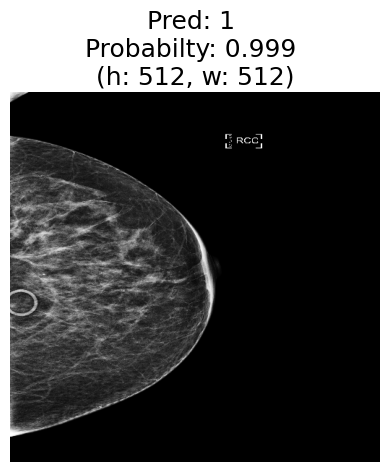

In [72]:
single_img_path_name = "view_dset_01_splitted_aug/cc_splitted/test/1/33971_1445458891.png"

pred_single_img(image_path=single_img_path_name,
              model=model_resNet0,
              transform=simple_transform2,
              class_names=class_names)